<a href="https://colab.research.google.com/github/flechasjd/INTROIA/blob/main/04_modelo_con_limpieza_de_otra_forma_y_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total
shape of loaded dataframe (692500, 21)
[2 2 0 1 0 0 0 0 3 0]
[0 3 1 3 3 0 0 1 0 3]
Train Accuracy: 0.36965703971119135
Test Accuracy: 0.3688519855595668


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286


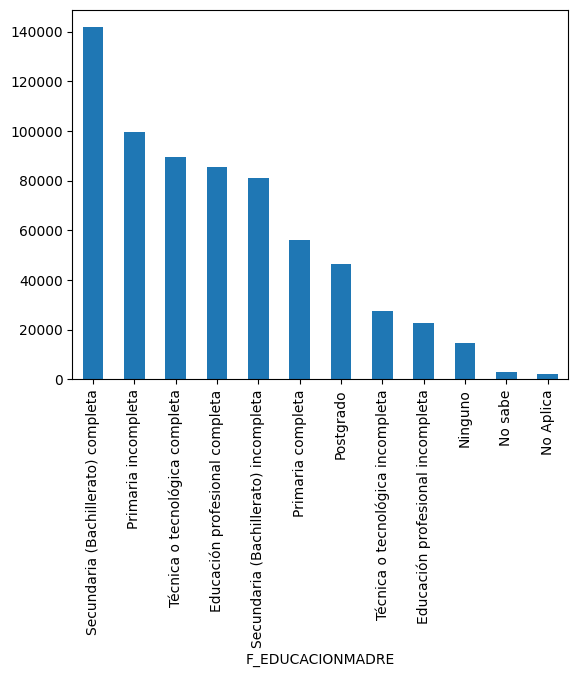

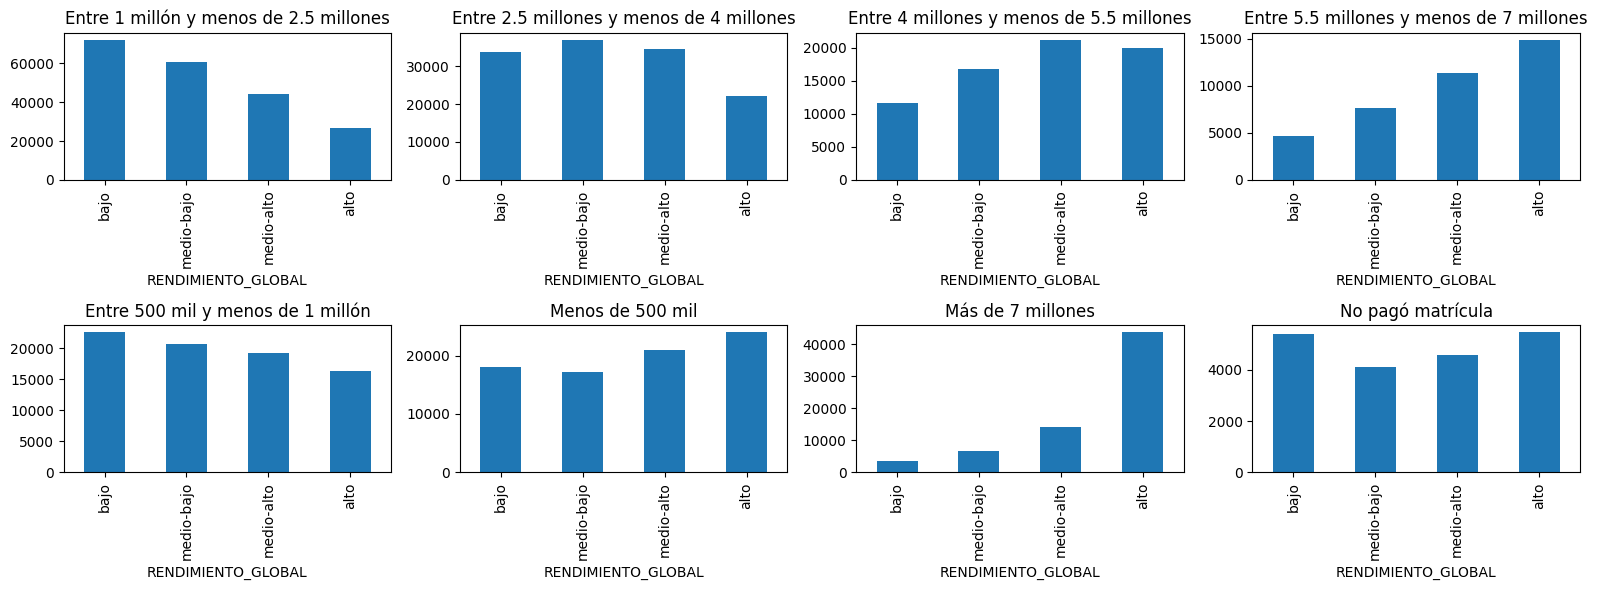

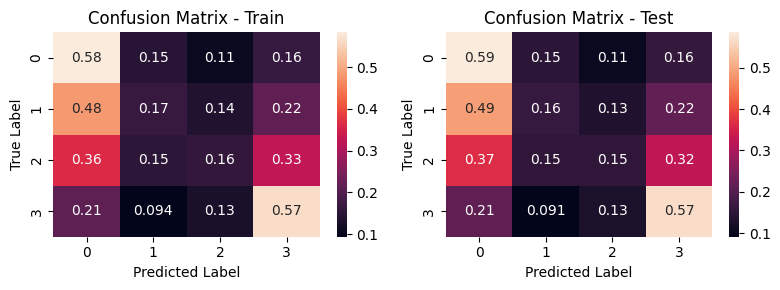

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

!unzip udea*.zip > /dev/null

!wc *.csv

import pandas as pd
import numpy as np

# Cargar los datos
z = pd.read_csv("train.csv")
print("shape of loaded dataframe", z.shape)

z.head()

# Seleccionar las columnas relevantes
z = z[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
z.head()

# Analizar las categorías en las columnas
z.F_EDUCACIONMADRE.value_counts().plot(kind='bar')

from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.E_VALORMATRICULAUNIVERSIDAD.value_counts().index)
for ax, ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.E_VALORMATRICULAUNIVERSIDAD == ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

# Reemplazar los valores nulos
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

# Reemplazar valores nulos
z.F_EDUCACIONMADRE.values[z.F_EDUCACIONMADRE.isna()] = 'no info'
z.E_VALORMATRICULAUNIVERSIDAD.values[z.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
sum(z.F_EDUCACIONMADRE.isna()), sum(z.E_VALORMATRICULAUNIVERSIDAD.isna())

# Detectar valores atípicos en ESTU_VALORMATRICULAUNIVERSIDAD
# Este es un PROCESO DE LIMPIEZA de valores atípicos con un enfoque diferente al ya utilizado antes

# Primero, verificamos las distribuciones de los valores para ver si hay valores inusuales
z.E_VALORMATRICULAUNIVERSIDAD.value_counts()

# Identificar valores fuera de rango y asignarlos a la mediana
valid_values = [
    'Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones',
    'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón',
    'Entre 4 millones y menos de 5.5 millones', 'Más de 7 millones',
    'Entre 5.5 millones y menos de 7 millones', 'No pagó matrícula'
]

# Reemplazar los valores no válidos por 'No pagó matrícula'
z.E_VALORMATRICULAUNIVERSIDAD = z.E_VALORMATRICULAUNIVERSIDAD.apply(lambda x: x if x in valid_values else 'No pagó matrícula')

# Ahora, realizamos el mapeo de valores como antes
cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Menos de 500 mil': 0.250,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 4 millones y menos de 5.5 millones': 4.75,
        'Más de 7 millones': 7.75,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'No pagó matrícula': 0,
        'no info': -1}

# Transformación de columna ESTU_VALORMATRICULAUNIVERSIDAD
z.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.E_VALORMATRICULAUNIVERSIDAD]]
z.E_VALORMATRICULAUNIVERSIDAD.value_counts()

# Limpiar la columna FAMI_EDUCACIONMADRE
z = z.copy()
z.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.F_EDUCACIONMADRE.values]

# Verificar los valores únicos de la columna
z.F_EDUCACIONMADRE.value_counts()

# Crear la codificación one-hot para la columna FAMI_EDUCACIONMADRE
x = z.F_EDUCACIONMADRE.values
F_EDUCACIONMADRE_vals = sorted(np.unique(x))
F_EDUCACIONMADRE_onehot_vals = {val: np.eye(len(F_EDUCACIONMADRE_vals))[i] for i, val in enumerate(F_EDUCACIONMADRE_vals)}
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in z.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])

# Concatenar los resultados one-hot y eliminar la columna original
z = pd.concat([F_EDUCACIONMADRE_df, z], axis=1).drop('F_EDUCACIONMADRE', axis=1)

# Mapeo para la columna RENDIMIENTO_GLOBAL
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'alto': 3, 'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2}
z[y_col] = [rmap[i] for i in z[y_col]]

# Preparar las variables de entrada y salida
z = z[sorted(z.columns)]
X = z[[c for c in z.columns if c != y_col]].values
y = z[y_col].values
X.shape, y.shape

# Dividir los datos en conjunto de entrenamiento y prueba
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

# Entrenar el modelo Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xtr, ytr)

# Predicciones
preds_tr = rf.predict(Xtr)
preds_ts = rf.predict(Xts)

print(preds_tr[:10])
print(preds_ts[:10])

# Evaluar el rendimiento del modelo
train_accuracy = np.mean(preds_tr == ytr)
test_accuracy = np.mean(preds_ts == yts)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Matriz de confusión
from sklearn.metrics import confusion_matrix

cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# Normalizar por clase
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1, 1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1, 1)

# Mostrar las matrices de confusión
import seaborn as sns
for ax, i in subplots(2, usizex=4):
    if i == 0:
        sns.heatmap(cm_tr, annot=True)
        plt.title("Confusion Matrix - Train")
    if i == 1:
        sns.heatmap(cm_ts, annot=True)
        plt.title("Confusion Matrix - Test")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

# Cargar los datos de prueba
zt = pd.read_csv("test.csv")
zt.head()

In [6]:
zt = pd.read_csv("test.csv")
zt

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Si,No,N,Si,Si,Si,Primaria completa,0.328,0.219,0.317,0.247
1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Técnica o tecnológica completa,0.227,0.283,0.296,0.324
2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.285,0.228,0.294,0.247
3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Si,No,N,No,No,No,Primaria incompleta,0.160,0.408,0.217,0.294
4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,0.209,0.283,0.306,0.286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Si,Si,N,Si,Si,Si,Primaria incompleta,0.168,0.410,0.235,0.300
296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.471,0.184,0.264,0.193
296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,Si,Si,Educación profesional completa,0.292,0.249,0.276,0.256
296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Si,No,N,No,Si,Si,Educación profesional completa,0.305,0.219,0.310,0.260


In [7]:
zt_ids = zt['ID'].values
zt = zt[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,F_EDUCACIONMADRE,E_VALORMATRICULAUNIVERSIDAD
0,Primaria completa,Menos de 500 mil
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) completa,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones


In [8]:
zt.F_EDUCACIONMADRE.values[zt.F_EDUCACIONMADRE.isna()] = 'no info'
zt.E_VALORMATRICULAUNIVERSIDAD.values[zt.E_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'

In [9]:
zt = zt.copy()
zt.E_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in zt.E_VALORMATRICULAUNIVERSIDAD]]

In [10]:
zt.F_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.F_EDUCACIONMADRE.values]
F_EDUCACIONMADRE_onehot_enc = np.r_[[F_EDUCACIONMADRE_onehot_vals[i] for i in zt.F_EDUCACIONMADRE]]
F_EDUCACIONMADRE_df = pd.DataFrame(F_EDUCACIONMADRE_onehot_enc, columns=[f"F_EDUCACIONMADRE__{v}" for v in F_EDUCACIONMADRE_onehot_vals])
zt = pd.concat([F_EDUCACIONMADRE_df, zt], axis=1).drop('F_EDUCACIONMADRE', axis=1)
zt.shape

(296786, 12)

In [11]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [12]:
preds_test_data = rf.predict(X_test_data)

In [13]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]

In [14]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,bajo
3,782980,bajo
4,785185,medio-bajo
...,...,...
296781,496981,bajo
296782,209415,bajo
296783,239074,medio-alto
296784,963852,alto


En esta limpieza:
Se hizo un análisis de la columna E_VALORMATRICULAUNIVERSIDAD para manejar valores atípicos. Además, después de limpiar y mapear las columnas, se pasó a entrenar un modelo Random Forest.

En la limpieza anterior:
La limpieza se centró principalmente en reemplazar valores nulos y codificar las columnas categóricas, sin analizar o modificar valores atípicos. Luego, se entrenó un modelo Gaussian Naive Bayes.